## Load Squad Data

In [126]:
from datasets import load_dataset
from transformers import AutoTokenizer

model_name = "deepset/gbert-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
dataset = load_dataset('squad', split='train')

In [127]:
def get_unique_context(dataset):
    contexts, ctx2title = set(), {}
    for row in dataset:
        title, ctx = row['title'], row['context']
        contexts.add(ctx)
        ctx2title[ctx] = title
    return list(contexts), ctx2title

In [128]:
contexts, ctx2title = get_unique_context(dataset)

In [129]:
ctx = contexts[11]
print(ctx, '\n', ctx2title[ctx])

Genes are regulated so that they are expressed only when the product is needed, since expression draws on limited resources.:7 A cell regulates its gene expression depending on its external environment (e.g. available nutrients, temperature and other stresses), its internal environment (e.g. cell division cycle, metabolism, infection status), and its specific role if in a multicellular organism. Gene expression can be regulated at any step: from transcriptional initiation, to RNA processing, to post-translational modification of the protein. The regulation of lactose metabolism genes in E. coli (lac operon) was the first such mechanism to be described in 1961. 
 Gene


In [130]:
enc = tokenizer(ctx)['input_ids']
print(enc[0:10])
print(tokenizer.decode(enc[0:10]))

[102, 20466, 30886, 5168, 10191, 3964, 262, 6711, 20294, 5168]
[CLS] Genes are regulated so that they are


In [131]:
from tqdm import tqdm

def encode_contexts(contexts):
    enc_ctx = []
    for ctx in tqdm(contexts):
        enc_ctx.append(tokenizer.encode(ctx, max_length=2048, truncation=True))
    return enc_ctx

In [132]:
encoded_contexts = encode_contexts(contexts)
max( list( len(e) for e in encoded_contexts ) )

100%|██████████| 18891/18891 [00:06<00:00, 2813.65it/s]


1236

In [133]:
def test_encode_decode(idx, encoded_contexts):
    print(contexts[idx])
    print(tokenizer.decode(encoded_contexts[idx]))

test_encode_decode(50, encoded_contexts)

Americans with Sub-Saharan African ancestry for historical reasons: slavery, partus sequitur ventrem, one-eighth law, the one-drop rule of 20th-century legislation, have frequently been classified as black (historically) or African American, even if they have significant European American or Native American ancestry. As slavery became a racial caste, those who were enslaved and others of any African ancestry were classified by what is termed "hypodescent" according to the lower status ethnic group. Many of majority European ancestry and appearance "married white" and assimilated into white society for its social and economic advantages, such as generations of families identified as Melungeons, now generally classified as white but demonstrated genetically to be of European and sub-Saharan African ancestry.
[CLS] Americans with Sub - Saharan African ancestry for historical reasons : slavery, partus sequitur ventrem, one - eighth law, the one - drop rule of 20th - century legislation, ha

In [134]:
def get_id2word(encoded_contexts):
    id2word = {}
    for enc_ctx in encoded_contexts:
        for enc_id in enc_ctx:
            if enc_id not in id2word:
                id2word[enc_id] = tokenizer.decode(enc_id)
    return id2word

In [135]:
id2word = get_id2word(encoded_contexts)

In [160]:
def decode_enc_context(encoded_contexts, id2word):
    tkn_context = []
    for enc_context in tqdm(encoded_contexts):
        tkns = []
        for enc_id in enc_context:
            tkns.append(id2word[enc_id])
        tkn_context.append(tkns)
    return tkn_context

In [161]:
tokenzied_context = decode_enc_context(encoded_contexts, id2word)

100%|██████████| 18891/18891 [00:00<00:00, 61803.77it/s]


In [163]:
tokenzied_context[0]

['[CLS]',
 'Bern',
 'has',
 'a',
 'popul',
 '##ation',
 'of',
 '140',
 ',',
 '63',
 '##4',
 'people',
 'and',
 '34',
 '%',
 'of',
 'the',
 'popul',
 '##ation',
 'are',
 'res',
 '##ident',
 'for',
 '##eign',
 'national',
 '##s',
 '.',
 'Over',
 'the',
 '10',
 'years',
 'between',
 '2000',
 'and',
 '2010',
 ',',
 'the',
 'popul',
 '##ation',
 'ch',
 '##ange',
 '##d',
 'at',
 'a',
 'rat',
 '##e',
 'of',
 '0',
 '.',
 '6',
 '%',
 '.',
 'Migration',
 'acc',
 '##ou',
 '##nte',
 '##d',
 'for',
 '1',
 '.',
 '3',
 '%',
 ',',
 'wh',
 '##ile',
 'bi',
 '##rt',
 '##hs',
 'and',
 'de',
 '##ath',
 '##s',
 'acc',
 '##ou',
 '##nte',
 '##d',
 'for',
 '−',
 '##2',
 '.',
 '1',
 '%',
 '.',
 '[SEP]']

In [170]:
def naive_tokenize(contexts):
    return [ctx.split(" ") for ctx in contexts]

In [171]:
naive_tokenized_context = naive_tokenize(contexts)

## Create Graph

In [183]:
import networkx as nx
import matplotlib.pyplot as plt


In [184]:
# nodes = id_vocab
# G.add_nodes_from(nodes)

In [185]:
# (node_a) --[context_id, ...]--> (node_b)
def create_graph(tokenzied_context):
    G = nx.Graph()
    for ctx_idx, context in tqdm(enumerate(tokenzied_context), total=len(tokenzied_context)):
        for i in range(len(context)-1):
            node_a, node_b = context[i], context[i+1] 
            G.add_nodes_from([node_a, node_b])
            if G.has_edge(node_a, node_b):
                G[node_a][node_b]['ctx_idx'].append(ctx_idx)
            else:
                G.add_edge(node_a, node_b, ctx_idx=[ctx_idx])
    return G

In [186]:
nG = create_graph(naive_tokenized_context)

100%|██████████| 18891/18891 [00:05<00:00, 3402.47it/s]


In [182]:
show_text_graph(nG, "./results/squad-graph.html")

./results/squad-graph.html


In [181]:
from networkx.readwrite import json_graph
data = json_graph.node_link_data(nG)
with open("./results/nG.json", 'w') as f:
    json.dump(data, f, indent=4)

In [ ]:
# plt.figure(3,figsize=(20,20)) 
# nx.draw(nG, with_labels=True, node_color='skyblue', node_size=200, font_size=10, font_weight='bold')


./results/squad-graph.html


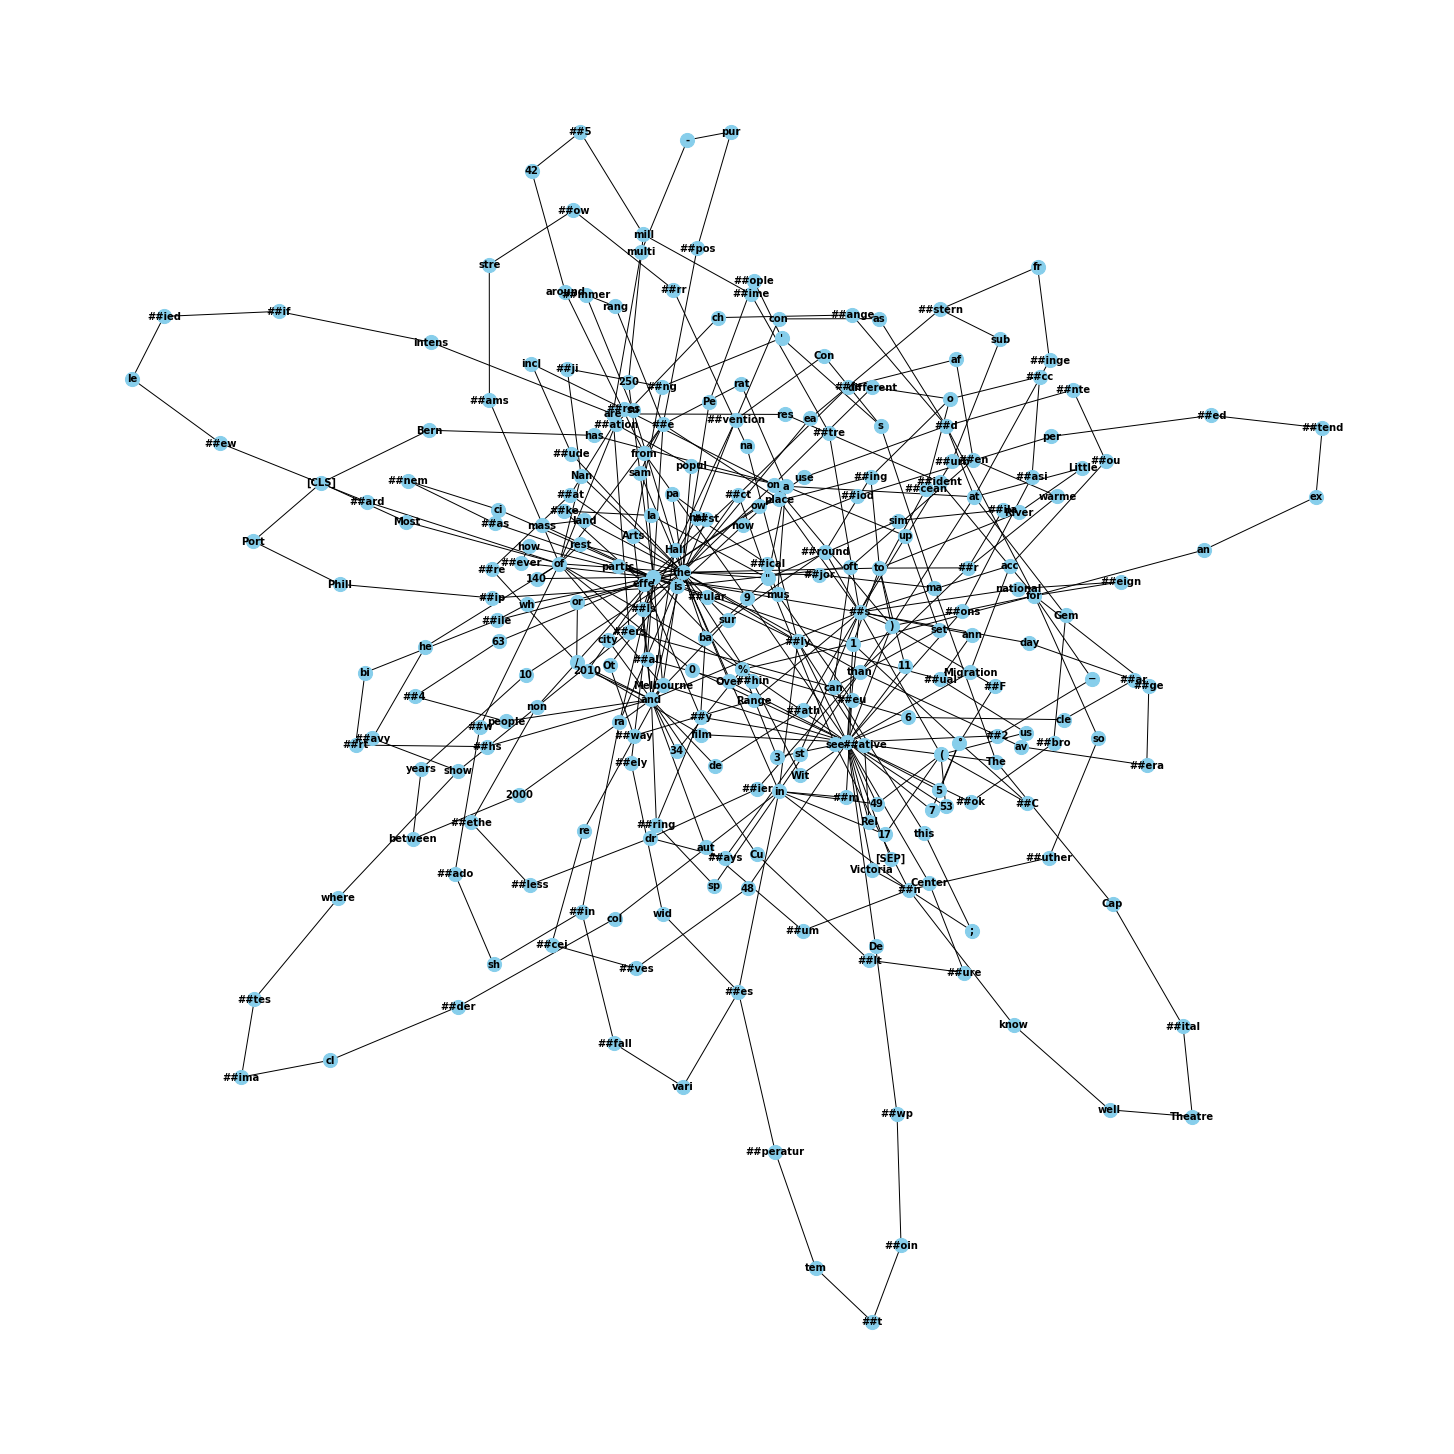